# 버트를 활용한 한국어 개체명 인식 모델

In [1]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A54E39C4-6B62-3303-9BE6-7DB88EB078BF> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/lib/python3.11/site-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transform

In [2]:
# 시각화

def plot_graphs(histroy, string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string])
    plt.show()


In [3]:
# random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS =3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = 'data_out/KOR'

In [4]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [5]:
train_ner_df

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O
...,...,...
80995,원숭이 중에서도 침팬지의 유전체 요율은 16.8%가 일치해 그 차이는 13.23%에...,O O ANM-B O O NUM-B O O O NUM-B O O O
80996,세터 장쉬가 한국도로공사에서 전속해오면서 인천시장 인생에 전환점을 맞았다 .,CVL-B PER-B ORG-B O CVL-B O O O O
80997,국립대학교는 20쿼터 5분여를 남겨두고 2-94로 추격했다 .,ORG-B NUM-B TIM-B O NUM-B O O
80998,위원회는 격전 KIA전에서 간탁 안정숙상의 30.1이닝 무실점 장병문 문경현호의 야...,ORG-B EVT-B EVT-I O PER-B NUM-B NUM-B PER-B PE...


In [6]:
drop_length = len(train_ner_df) // 5
train_ner_df = train_ner_df[:drop_length]
train_ner_df

,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O
...,...,...
16195,큰 축원경으로는 지구에서 15억광년 떨어진 곳에 있는 은하수도 볼 수 있는데요 .,O O O NUM-B O O O O O O O O
16196,"그는 이 지르텍PC가 포맷된 어떤 SW가 설비됐는지 말하고, 노트북PC 속의 지워진...",O O TRM-B O O TRM-B O O TRM-B O O O O O O O O ...
16197,손은서가 부진으로 20군으로 내려가 마커스의 에이스 역할이 요구되는 상태 .,PER-B O NUM-B O PER-B CVL-B O O O O
16198,-그렇게 케이트의 용지를 살피는 오상자이엘 .,O PER-B O O ORG-B O


In [7]:
# Label 불러오기
# label 사전에서 확인할 것 

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path),'r',encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print(f"개체명 인식 레이블 개수: {len(ner_labels)}")


개체명 인식 레이블 개수: 30


In [8]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert-ckpt', clean_up_tokenization_spaces=True)

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

loading file vocab.txt from cache at bert-ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert-ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer_config.json
loading file tokenizer.json from cache at bert-ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer.json
loading configuration file config.json from cache at bert-ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropou

In [9]:
def bert_tokenizer(sent, MAX_LEN):
    encoded_dict = tokenizer.encode_plus(
        text = sent, 
        truncation=True,
        add_special_tokens = True, # [CLS] 와 [SEP]추가
        max_length = MAX_LEN,       # 문장 패팅 및 자르기 진행
        # pad_to_max_length = True, # 버젼으로 인한 문구 변경 -> padding
        padding = 'max_length',
        return_attention_mask= True # 어텐션 마스크 설정
    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']

    return input_id, attention_mask, token_type_id

# BERT 토크나이저로 문장을 토큰화하고 레이블을 변환하는 함수
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):

    tokens = []  # 문장을 BERT 토크나이저로 토큰화한 토큰들을 저장하는 리스트
    label_ids = []  # 토큰에 대응하는 레이블 인덱스를 저장하는 리스트

    # 단어와 각 단어에 대응하는 NER 레이블을 반복 처리
    for word, slot_label in zip(words, labels_idx):

        # 단어를 BERT 토크나이저로 토큰화
        word_tokens = tokenizer.tokenize(word)

        # 만약 단어가 토큰화되지 않는 경우(토큰이 없으면), [UNK] 토큰을 대신 사용
        if not word_tokens:
            word_tokens = [unk_token]
        
        # 토큰화된 단어들을 tokens 리스트에 추가
        tokens.extend(word_tokens)

        # 슬롯 레이블이 NER Begin(B-) 레이블인 경우 (예: B-PER), 첫 번째 토큰에만 Begin 레이블을, 나머지 토큰에는 Inside(I-) 레이블 추가
        if int(slot_label) in ner_begin_label:
            # 첫 번째 토큰에는 Begin 레이블, 나머지 토큰에는 Inside 레이블을 추가
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            # Begin 레이블이 아닌 경우는 모든 토큰에 동일한 레이블을 적용
            label_ids.extend([int(slot_label)] * len(word_tokens))

    # 특수 토큰 [CLS]와 [SEP]이 필요하므로 그만큼 시퀀스 길이를 제한 (BERT 입력 형식에 맞게)
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        # 최대 시퀀스 길이를 넘지 않도록 label_ids를 자름
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰에 해당하는 레이블을 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰에 해당하는 레이블을 추가하고, 기존 레이블을 연결
    label_ids = [cls_token_label_id] + label_ids

    # 시퀀스 길이를 max_seq_len에 맞추기 위해 패딩을 추가
    padding_length = max_seq_len - len(label_ids)
    # 패딩 레이블을 추가하여 시퀀스 길이를 맞춤
    label_ids = label_ids + ([pad_token_label_id] * padding_length)

    return label_ids  # 변환된 레이블 리스트를 반환

In [10]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label)for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [11]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

In [12]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [13]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}

loading weights file model.safetensors from cache at bert_c

In [14]:
# 손실함수에 대하여 커스텀 하는 함수
def compute_loss(labels, logits):
    # SparseCategoricalCrossentropy 손실 함수 정의
    # from_logits=True: 로짓 값을 입력으로 받아 내부에서 소프트맥스를 적용
    # reduction=tf.keras.losses.Reduction.NONE: 각 데이터 포인트에 대해 개별적인 손실 값을 반환
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 계산에서 제외하기 위해 마스크 생성
    # labels를 1D 형태로 변환하고, 값이 0이 아닌 부분에 대해서만 True인 마스크를 생성
    active_loss = tf.reshape(labels, (-1,)) != 0

    # logits도 1D 형태로 변환한 후, active_loss가 True인 부분만 남긴다
    # shape_list(logits)[2]는 logits의 마지막 차원의 크기를 의미 (클래스 수)
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)

    # labels도 active_loss가 True인 값만 남긴다
    # 0인 레이블은 손실 계산에서 제외되므로, 해당 부분에 대해 마스크를 적용
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)

    # 손실 값을 계산하고 반환
    return loss_fn(labels, reduced_logits)


In [15]:
# F1Metrics 클래스는 keras의 콜백을 상속받아 모델 평가 시 F1 점수를 계산하는 클래스
class F1Metrics(tf.keras.callbacks.Callback):
    # 클래스 초기화
    def __init__(self, x_eval, y_eval):
        # 평가할 데이터셋을 입력으로 받음
        self.x_eval = x_eval  # 평가용 입력 데이터
        self.y_eval = y_eval  # 평가용 레이블 데이터

    # F1 점수, precision(정밀도), recall(재    현율)을 계산하는 함수
    def compute_f1_pre_rec(self, labels, preds):
        return {
            "precision": precision_score(labels, preds, suffix=True),  # 정밀도 계산
            "recall": recall_score(labels, preds, suffix=True),          # 재현율 계산
            "f1": f1_score(labels, preds, suffix=True)                   # F1 점수 계산
        }

    # classification_report 출력 (자세한 분류 성능 보고서 출력)
    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)

    # 각 에포크가 끝날 때마다 호출
    def on_epoch_end(self, epoch, logs=None):
        results = {}  # 평가 결과 저장용 딕셔너리
        
        # 모델에 평가용 데이터를 입력하여 예측값 생성
        pred = self.model.predict(self.x_eval)  # 평가 데이터에 대한 예측값
        label = self.y_eval  # 실제 레이블
        pred_argmax = np.argmax(pred, axis=2)  # 예측 결과에서 가장 높은 확률을 가진 클래스 선택 (argmax)

        # NER 레이블 맵 (숫자 인덱스를 실제 레이블 이름으로 매핑)
        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        # 각 문장마다 실제 레이블과 예측 레이블을 저장할 리스트 초기화
        out_label_list = [[] for _ in range(label.shape[0])]  # 실제 레이블
        preds_list = [[] for _ in range(label.shape[0])]      # 예측 레이블

        # 각 문장과 각 토큰에 대해 실제 레이블과 예측 레이블을 수집
        for i in range(label.shape[0]):  # 문장 단위로 반복
            for j in range(label.shape[1]):  # 각 문장 안에서 토큰 단위로 반복
                # 레이블이 0(패딩)이 아닌 경우에만 레이블을 수집
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])  # 실제 레이블
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])  # 예측된 레이블

        # 수집된 실제 레이블과 예측 레이블로 F1, precision, recall 계산
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)  # 결과를 저장

        # F1 점수와 각 지표 출력
        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):  # precision, recall, f1 순서로 출력
            print("{}, {:.4f}".format(key, results[key]))
        # 상세한 classification_report 출력
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

# F1Metrics 콜백을 생성하고, 평가 데이터로 초기화
f1_score_callback = F1Metrics(test_inputs, test_labels)


In [16]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer= optimizer, loss=compute_loss)

In [17]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, '.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
# cp_callback = ModelCheckpoint(
#     checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True, motinor='loss')

cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR/tf2_bert_ner -- Folder already exists 

Epoch 1/3
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 2.8953

/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 698s 2s/step
********
F1 Score
f1, 0.0009
precision, 0.0019
recall, 0.0005


/opt/anaconda3/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



              precision    recall  f1-score   support

         AFW       0.00      0.00      0.00       393
         ANM       0.00      0.00      0.00       699
         CVL       0.00      0.00      0.00      5735
         DAT       0.00      0.00      0.00      2510
         EVT       0.00      0.00      0.00      1093
         FLD       0.00      0.00      0.00       228
         LOC       0.00      0.00      0.00      2124
         MAT       0.00      0.00      0.00        12
         NUM       0.01      0.00      0.00      5544
         ORG       0.00      0.00      0.00      4055
         PER       0.00      0.00      0.00      4412
         PLT       0.00      0.00      0.00        34
         TIM       0.00      0.00      0.00       314
         TRM       0.00      0.00      0.00      1950

   micro avg       0.00      0.00      0.00     29103
   macro avg       0.00      0.00      0.00     29103
weighted avg       0.00      0.00      0.00     29103

********
507/507 ━━━━━━━

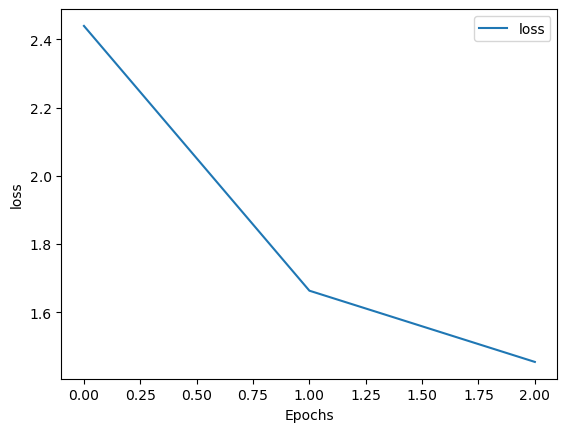

In [18]:
plot_graphs(history, 'loss')